In [3]:
from mapper import write_time_based_train_test_split
from mapper import map_to_PGPR

In [2]:
dataset_name = 'lfm'

In [3]:
#write_time_based_train_test_split(dataset_name, "pgpr", 0.8)

KeyboardInterrupt: 

In [4]:
#map_to_PGPR('lfm')

In [1]:
%cd models/PGPR


/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR


In [6]:
%run preprocess.py --dataset lfm

Load lfm dataset from file...
Load user of size 9455
Load product of size 173788
Load artist of size 14987
Load album of size 45978
Load genre of size 749
Load micro_genre of size 1921
Load in_album of size 111577
Load has_micro_genre of size 667023
Load created_by of size 111577
Load has_genre of size 111577
0 0
Load review of size 3941518 with positive reviews= 0  and negative reviews= 3941518
Create lfm knowledge graph from dataset...
Load entities...
Total 246884 nodes.
Load reviews...
Total 7883036 review edges.
Load knowledge created_by...
Total 223154 created_by edges.
Load knowledge has_micro_genre...
Total 1334046 has_micro_genre edges.
Load knowledge has_genre...
Total 223154 has_genre edges.
Load knowledge in_album...
Total 223154 in_album edges.
Remove duplicates...
Compute node degrees...
Generate lfm train/test labels.


In [2]:
%run train_transe_model --dataset lfm

../../data/lfm/preprocessed/pgpr/tmp
[INFO]  Namespace(dataset='lfm', name='train_transe_model', seed=123, gpu='0', epochs=30, batch_size=64, lr=0.5, weight_decay=0, l2_lambda=0, max_grad_norm=5.0, embed_size=100, num_neg_samples=5, steps_per_checkpoint=200, device=device(type='cuda', index=0), log_dir='../../data/lfm/preprocessed/pgpr/tmp/train_transe_model')
[INFO]  Parameters:['listened_to', 'created_by', 'in_album', 'has_genre', 'has_micro_genre', 'user.weight', 'product.weight', 'artist.weight', 'micro_genre.weight', 'album.weight', 'genre.weight', 'listened_to_bias.weight', 'created_by_bias.weight', 'in_album_bias.weight', 'has_genre_bias.weight', 'has_micro_genre_bias.weight']


KeyboardInterrupt: 

In [3]:
%run train_agent --dataset lfm --label high_entropy --ent_weight 8e-3

[INFO]  Namespace(dataset='lfm', name='train_agent', seed=123, gpu='0', epochs=50, batch_size=32, lr=0.0001, max_acts=250, max_path_len=3, gamma=0.99, ent_weight=0.008, act_dropout=0, state_history=1, hidden=[512, 256], label='high_entropy', device=device(type='cuda', index=0), log_dir='../../data/lfm/preprocessed/pgpr/tmp/train_agent')
Load embedding: ../../data/lfm/preprocessed/pgpr/tmp/transe_embed.pkl
[INFO]  Parameters:['l1.weight', 'l1.bias', 'l2.weight', 'l2.bias', 'actor.weight', 'actor.bias', 'critic.weight', 'critic.bias']


/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR/train_agent.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  actor_logits[1 - act_mask] = -999999.0
/home/jfallmann/miniconda3/envs/bsc/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

In [3]:
%run test_agent --dataset lfm --label high_entropy

Predicting paths...
Load embedding: ../../data/lfm/preprocessed/pgpr/tmp/transe_embed.pkl


  0%|          | 0/9455 [00:00<?, ?it/s]/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR/train_agent.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  actor_logits[1 - act_mask] = -999999.0
9456it [3:41:39,  1.41s/it]                            


Load embedding: ../../data/lfm/preprocessed/pgpr/tmp/transe_embed.pkl
Normalizing items scores...
Saving pred_paths...
Average test set size:  104.71782125859333
Overall for noOfUser=9455, ndcg=0.0834


Overall for noOfUser=9455, hr=0.1578


Overall for noOfUser=9455, precision=0.0207


Overall for noOfUser=9455, recall=0.0023


In [2]:
%run train_agent --dataset lfm --label medium_entropy_2 --ent_weight 1e-3

[INFO]  Namespace(dataset='lfm', name='train_agent', seed=123, gpu='0', epochs=50, batch_size=32, lr=0.0001, max_acts=250, max_path_len=3, gamma=0.99, ent_weight=0.001, act_dropout=0, state_history=1, hidden=[512, 256], label='medium_entropy_2', device=device(type='cuda', index=0), log_dir='../../data/lfm/preprocessed/pgpr/tmp/train_agent')
Load embedding: ../../data/lfm/preprocessed/pgpr/tmp/transe_embed.pkl
[INFO]  Parameters:['l1.weight', 'l1.bias', 'l2.weight', 'l2.bias', 'actor.weight', 'actor.bias', 'critic.weight', 'critic.bias']


/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR/train_agent.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  actor_logits[1 - act_mask] = -999999.0
/home/jfallmann/miniconda3/envs/bsc/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[INFO]  epoch/step=1/100 | loss=0.36861 | ploss=0.25825 | vloss=0.12479 | entropy=-14.42689 | relation entropy=0.48818 | ratio=0.11234 | reward=0.15642
[INFO]  epoch/step=1/200 | loss=0.20526 | ploss=0.09772 | vloss=0.12191 | entropy=-14.36923 | relation entropy=0.49887 | ratio=0.11203 | reward=0.16032
[INFO]  epoch/step=2/300 | loss=0.21810 | ploss=0.11409 | vloss=0.11837 | entropy=-14.36129 | relation entropy=0.52241 | ratio=0.12016 | reward=0.16032
[INFO]  epoch/step=2/400 | loss=0.15636 | ploss=0.05695 | vloss=0.11380 | entropy=-14.38098 | relation entropy=0.48317 | ratio=0.10781 | reward=0.16291
[INFO]  epoch/step=2/500 | loss=0.17567 | ploss=0.08174 | vloss=0.10832 | entropy=-14.38770 | relation entropy=0.48352 | ratio=0.11250 | reward=0.16095
[INFO]  epoch/step=3/600 | loss=0.15228 | ploss=0.06455 | vloss=0.10211 | entropy=-14.38035 | relation entropy=0.48310 | ratio=0.11281 | reward=0.15869
[INFO]  epoch/step=3/700 | loss=0.17428 | ploss=0.08347 | vloss=0.10524 | entropy=-14.42

In [1]:
%run test_agent --dataset lfm --label medium_entropy

Exception: File `'test_agent'` not found.

In [2]:
%run train_agent --dataset lfm --label medium_high_entropy --ent_weight 5e-3


[INFO]  Namespace(dataset='lfm', name='train_agent', seed=123, gpu='0', epochs=50, batch_size=32, lr=0.0001, max_acts=250, max_path_len=3, gamma=0.99, ent_weight=0.005, act_dropout=0, state_history=1, hidden=[512, 256], label='medium_high_entropy', device=device(type='cuda', index=0), log_dir='../../data/lfm/preprocessed/pgpr/tmp/train_agent')
Load embedding: ../../data/lfm/preprocessed/pgpr/tmp/transe_embed.pkl
[INFO]  Parameters:['l1.weight', 'l1.bias', 'l2.weight', 'l2.bias', 'actor.weight', 'actor.bias', 'critic.weight', 'critic.bias']


/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR/train_agent.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  actor_logits[1 - act_mask] = -999999.0


KeyboardInterrupt: 

In [7]:
%run test_agent --dataset lfm --label medium_high_entropy

Predicting paths...
Load embedding: ../../data/lfm/preprocessed/pgpr/tmp/transe_embed.pkl


  0%|          | 0/9455 [00:00<?, ?it/s]/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR/train_agent.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  actor_logits[1 - act_mask] = -999999.0
9456it [3:43:01,  1.42s/it]                            


Load embedding: ../../data/lfm/preprocessed/pgpr/tmp/transe_embed.pkl
Normalizing items scores...
Saving pred_paths...
Average test set size:  104.71782125859333
Overall for noOfUser=9455, ndcg=0.0837


Overall for noOfUser=9455, hr=0.1551


Overall for noOfUser=9455, precision=0.0205


Overall for noOfUser=9455, recall=0.0023


In [8]:
%run train_agent --dataset lfm --label low_entropy --ent_weight 1e-4

[INFO]  Namespace(dataset='lfm', name='train_agent', seed=123, gpu='0', epochs=50, batch_size=32, lr=0.0001, max_acts=250, max_path_len=3, gamma=0.99, ent_weight=0.0001, act_dropout=0, state_history=1, hidden=[512, 256], label='low_entropy', device=device(type='cuda', index=0), log_dir='../../data/lfm/preprocessed/pgpr/tmp/train_agent')
[INFO]  Namespace(dataset='lfm', name='train_agent', seed=123, gpu='0', epochs=50, batch_size=32, lr=0.0001, max_acts=250, max_path_len=3, gamma=0.99, ent_weight=0.0001, act_dropout=0, state_history=1, hidden=[512, 256], label='low_entropy', device=device(type='cuda', index=0), log_dir='../../data/lfm/preprocessed/pgpr/tmp/train_agent')
[INFO]  Namespace(dataset='lfm', name='train_agent', seed=123, gpu='0', epochs=50, batch_size=32, lr=0.0001, max_acts=250, max_path_len=3, gamma=0.99, ent_weight=0.0001, act_dropout=0, state_history=1, hidden=[512, 256], label='low_entropy', device=device(type='cuda', index=0), log_dir='../../data/lfm/preprocessed/pgpr/t

/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR/train_agent.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  actor_logits[1 - act_mask] = -999999.0
/home/jfallmann/miniconda3/envs/bsc/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[INFO]  epoch/step=1/100 | loss=0.38819 | ploss=0.26202 | vloss=0.12761 | entropy=-14.42892 | reward=0.15809
[INFO]  epoch/step=1/100 | loss=0.38819 | ploss=0.26202 | vloss=0.12761 | entropy=-14.42892 | reward=0.15809
[INFO]  epoch/step=1/100 | loss=0.38819 | ploss=0.26202 | vloss=0.12761 | entropy=-14.42892 | reward=0.15809
[INFO]  epoch/step=1/100 | loss=0.38819 | ploss=0.26202 | vloss=0.12761 | entropy=-14.42892 | reward=0.15809
[INFO]  epoch/step=1/200 | loss=0.21835 | ploss=0.09777 | vloss=0.12201 | entropy=-14.37078 | reward=0.16013
[INFO]  epoch/step=1/200 | loss=0.21835 | ploss=0.09777 | vloss=0.12201 | entropy=-14.37078 | reward=0.16013
[INFO]  epoch/step=1/200 | loss=0.21835 | ploss=0.09777 | vloss=0.12201 | entropy=-14.37078 | reward=0.16013
[INFO]  epoch/step=1/200 | loss=0.21835 | ploss=0.09777 | vloss=0.12201 | entropy=-14.37078 | reward=0.16013
[INFO]  epoch/step=2/300 | loss=0.23253 | ploss=0.11533 | vloss=0.11864 | entropy=-14.36027 | reward=0.16028
[INFO]  epoch/step=

In [9]:
%run test_agent --dataset lfm --label low_entropy

Predicting paths...
Load embedding: ../../data/lfm/preprocessed/pgpr/tmp/transe_embed.pkl


  0%|          | 0/9455 [00:00<?, ?it/s]/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR/train_agent.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  actor_logits[1 - act_mask] = -999999.0
9456it [3:38:57,  1.39s/it]                            


Load embedding: ../../data/lfm/preprocessed/pgpr/tmp/transe_embed.pkl
Normalizing items scores...
Saving pred_paths...
Average test set size:  104.71782125859333
Overall for noOfUser=9455, ndcg=0.0852


Overall for noOfUser=9455, hr=0.1573


Overall for noOfUser=9455, precision=0.0207


Overall for noOfUser=9455, recall=0.0023


In [10]:
%run train_agent --dataset lfm --label no_entropy --ent_weight 0

[INFO]  Namespace(dataset='lfm', name='train_agent', seed=123, gpu='0', epochs=50, batch_size=32, lr=0.0001, max_acts=250, max_path_len=3, gamma=0.99, ent_weight=0.0, act_dropout=0, state_history=1, hidden=[512, 256], label='no_entropy', device=device(type='cuda', index=0), log_dir='../../data/lfm/preprocessed/pgpr/tmp/train_agent')
[INFO]  Namespace(dataset='lfm', name='train_agent', seed=123, gpu='0', epochs=50, batch_size=32, lr=0.0001, max_acts=250, max_path_len=3, gamma=0.99, ent_weight=0.0, act_dropout=0, state_history=1, hidden=[512, 256], label='no_entropy', device=device(type='cuda', index=0), log_dir='../../data/lfm/preprocessed/pgpr/tmp/train_agent')
[INFO]  Namespace(dataset='lfm', name='train_agent', seed=123, gpu='0', epochs=50, batch_size=32, lr=0.0001, max_acts=250, max_path_len=3, gamma=0.99, ent_weight=0.0, act_dropout=0, state_history=1, hidden=[512, 256], label='no_entropy', device=device(type='cuda', index=0), log_dir='../../data/lfm/preprocessed/pgpr/tmp/train_age

/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR/train_agent.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  actor_logits[1 - act_mask] = -999999.0
/home/jfallmann/miniconda3/envs/bsc/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[INFO]  epoch/step=1/100 | loss=0.38964 | ploss=0.26202 | vloss=0.12761 | entropy=-14.42892 | reward=0.15809
[INFO]  epoch/step=1/100 | loss=0.38964 | ploss=0.26202 | vloss=0.12761 | entropy=-14.42892 | reward=0.15809
[INFO]  epoch/step=1/100 | loss=0.38964 | ploss=0.26202 | vloss=0.12761 | entropy=-14.42892 | reward=0.15809
[INFO]  epoch/step=1/100 | loss=0.38964 | ploss=0.26202 | vloss=0.12761 | entropy=-14.42892 | reward=0.15809
[INFO]  epoch/step=1/100 | loss=0.38964 | ploss=0.26202 | vloss=0.12761 | entropy=-14.42892 | reward=0.15809
[INFO]  epoch/step=1/200 | loss=0.21979 | ploss=0.09777 | vloss=0.12201 | entropy=-14.37078 | reward=0.16013
[INFO]  epoch/step=1/200 | loss=0.21979 | ploss=0.09777 | vloss=0.12201 | entropy=-14.37078 | reward=0.16013
[INFO]  epoch/step=1/200 | loss=0.21979 | ploss=0.09777 | vloss=0.12201 | entropy=-14.37078 | reward=0.16013
[INFO]  epoch/step=1/200 | loss=0.21979 | ploss=0.09777 | vloss=0.12201 | entropy=-14.37078 | reward=0.16013
[INFO]  epoch/step=

In [11]:
%run test_agent --dataset lfm --label no_entropy

Predicting paths...
Load embedding: ../../data/lfm/preprocessed/pgpr/tmp/transe_embed.pkl


  0%|          | 0/9455 [00:00<?, ?it/s]/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR/train_agent.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  actor_logits[1 - act_mask] = -999999.0
9456it [3:40:57,  1.40s/it]                            


Load embedding: ../../data/lfm/preprocessed/pgpr/tmp/transe_embed.pkl
Normalizing items scores...
Saving pred_paths...
Average test set size:  104.71782125859333
Overall for noOfUser=9455, ndcg=0.0843


Overall for noOfUser=9455, hr=0.1571


Overall for noOfUser=9455, precision=0.0207


Overall for noOfUser=9455, recall=0.0024


In [1]:
%cd models/PGPR
%run train_agent --dataset lfm --label rel_entropy --ent_weight 1e-3

/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR
[INFO]  Namespace(dataset='lfm', name='train_agent', seed=1234, gpu='0', epochs=50, batch_size=32, lr=0.0001, max_acts=250, max_path_len=3, gamma=0.99, ent_weight=0.001, act_dropout=0, state_history=1, hidden=[512, 256], label='rel_entropy', device=device(type='cuda', index=0), log_dir='../../data/lfm/preprocessed/pgpr/tmp/train_agent')
Load embedding: ../../data/lfm/preprocessed/pgpr/tmp/transe_embed.pkl
[INFO]  Parameters:['l1.weight', 'l1.bias', 'l2.weight', 'l2.bias', 'actor.weight', 'actor.bias', 'critic.weight', 'critic.bias']


/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR/train_agent.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  actor_logits[1 - act_mask] = -999999.0
/home/jfallmann/miniconda3/envs/bsc/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[INFO]  epoch/step=1/100 | loss=0.41904 | ploss=0.34697 | vloss=0.08643 | entropy=-14.35701 | relation entropy=0.49741 | ratio=0.11406 | reward=0.19614
[INFO]  epoch/step=1/200 | loss=0.17702 | ploss=0.11581 | vloss=0.07561 | entropy=-14.39261 | relation entropy=0.50714 | ratio=0.11797 | reward=0.19672
[INFO]  epoch/step=2/300 | loss=0.14368 | ploss=0.08723 | vloss=0.07088 | entropy=-14.43810 | relation entropy=0.49550 | ratio=0.11531 | reward=0.19443
[INFO]  epoch/step=2/400 | loss=0.15732 | ploss=0.10239 | vloss=0.06931 | entropy=-14.38283 | relation entropy=0.47847 | ratio=0.11406 | reward=0.19923
[INFO]  epoch/step=2/500 | loss=0.15037 | ploss=0.09579 | vloss=0.06897 | entropy=-14.38460 | relation entropy=0.51911 | ratio=0.12578 | reward=0.19975
[INFO]  epoch/step=3/600 | loss=0.09793 | ploss=0.04655 | vloss=0.06577 | entropy=-14.39157 | relation entropy=0.49861 | ratio=0.12375 | reward=0.19710
[INFO]  epoch/step=3/700 | loss=0.12578 | ploss=0.07636 | vloss=0.06379 | entropy=-14.38

In [2]:
%run test_agent --dataset lfm --label rel_entropy

Predicting paths...
Load embedding: ../../data/lfm/preprocessed/pgpr/tmp/transe_embed.pkl


  0%|          | 0/9455 [00:00<?, ?it/s]/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR/train_agent.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Indexing.cu:1440.)
  actor_logits[1 - act_mask] = -999999.0
9456it [9:46:44,  3.72s/it]                            


Load embedding: ../../data/lfm/preprocessed/pgpr/tmp/transe_embed.pkl
Normalizing items scores...
Saving pred_paths...
Average test set size:  104.71782125859333
Overall for noOfUser=9455, ndcg=0.0781


Overall for noOfUser=9455, hr=0.1523


Overall for noOfUser=9455, precision=0.0181


Overall for noOfUser=9455, recall=0.0019


In [12]:
import numpy as np
import pandas as pd
from random import seed, randint, choice
from collections import defaultdict
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
sns.set() 

In [ ]:
regex = "(?<=relation entropy=).*?(?= \|)"

In [37]:
rel_entropy_new = [0.48818, 0.50714, 0.49550, 0.47847, 0.51911, 0.49861, 0.52027, 0.52584, 0.55525, 0.53797, 0.60381, 0.60978, 0.74329, 0.89678, 0.86269, 0.76198, 0.75870, 0.70845, 0.70840, 0.73807, 0.72996, 0.71597, 0.69036, 0.70247, 0.67724, 0.68045, 0.66649, 0.68729, 0.68591, 0.67892, 0.66475, 0.69001, 0.66177, 0.68257, 0.67012, 0.66778, 0.66045, 0.66554, 0.65001, 0.66512, 0.67469, 0.67095, 0.67121, 0.65868, 0.66455, 0.65442, 0.67139, 0.65897, 0.67377, 0.68465, 0.67124, 0.67576, 0.66084, 0.67252, 0.66690, 0.65749, 0.64938, 0.65240, 0.63310, 0.63369, 0.64757, 0.65324, 0.64224, 0.64440, 0.65192, 0.65603, 0.66144, 0.66532, 0.63798, 0.64755, 0.64252, 0.65917, 0.64684, 0.65663, 0.65758, 0.65200, 0.65240, 0.64664, 0.64936, 0.64791, 0.64236, 0.65308, 0.65925, 0.65970, 0.64705, 0.65149, 0.65465, 0.66932, 0.65725, 0.65383, 0.64026, 0.65440, 0.64732, 0.64306, 0.64702, 0.64752, 0.65291, 0.66090, 0.65630, 0.65523, 0.66126, 0.65687, 0.63958, 0.65382, 0.64738, 0.64806, 0.63513, 0.65017, 0.64873, 0.65844, 0.65366, 0.65495, 0.63804, 0.64658, 0.64877, 0.65800, 0.64813, 0.64892, 0.65060, 0.65378, 0.64742, 0.65477, 0.64782, 0.65212, 0.63594, 0.64879, 0.65429, 0.64529, 0.64204, 0.65680, 0.66370, 0.64652, 0.64534, 0.64395, 0.65672, 0.64400, 0.65907, 0.64754, 0.63869, 0.64100, 0.63799, 0.63330, 0.63900, 0.65101, 0.64320, 0.65978, 0.65172, 0.64342]

relation_entropy_old = [0.48818, 0.49887, 0.52241, 0.48317, 0.48352, 0.48310, 0.48103, 0.47976, 0.44389, 0.44561, 0.46272, 0.46227, 0.46930, 0.41186, 0.46662, 0.43487, 0.45312, 0.44440, 0.44238, 0.41109, 0.40825, 0.44968, 0.39049, 0.41200, 0.40051, 0.39489, 0.39146, 0.40732, 0.37568, 0.37338, 0.37764, 0.36770, 0.36179, 0.36133, 0.34361, 0.36936, 0.37616, 0.36097, 0.39746, 0.36732, 0.31538, 0.35724, 0.32989, 0.34363, 0.35228, 0.36201, 0.33909, 0.33507, 0.33071, 0.29757, 0.31781, 0.31934, 0.33670, 0.31509, 0.28922, 0.32868, 0.30186, 0.32034, 0.28872, 0.26685, 0.30263, 0.28668, 0.29649, 0.32021, 0.30769, 0.28563, 0.27643, 0.29203, 0.26496, 0.27325, 0.25925, 0.28916, 0.29010, 0.25571, 0.28149, 0.25383, 0.25721, 0.25361, 0.24074, 0.24894, 0.23059, 0.23697, 0.24563, 0.26135, 0.25092, 0.24941, 0.19190, 0.22049, 0.21439, 0.22420, 0.23622, 0.22704, 0.21972, 0.21117, 0.20278, 0.21346, 0.20862, 0.18287, 0.20198, 0.19594, 0.18295, 0.20770, 0.20844, 0.19775, 0.18735, 0.19729, 0.19936, 0.18943, 0.19138, 0.16642, 0.20255, 0.18225, 0.16980, 0.21577, 0.18882, 0.18139, 0.18392, 0.16523, 0.17789, 0.16330, 0.19993, 0.17708, 0.18002, 0.16697, 0.18140, 0.19494, 0.19233, 0.16387, 0.19037, 0.20377, 0.15981, 0.17469, 0.18342, 0.18799, 0.17970, 0.18768, 0.20521, 0.19089, 0.14175, 0.16679, 0.18287, 0.17812, 0.17808, 0.16954, 0.17316, 0.15955, 0.17061, 0.18958]

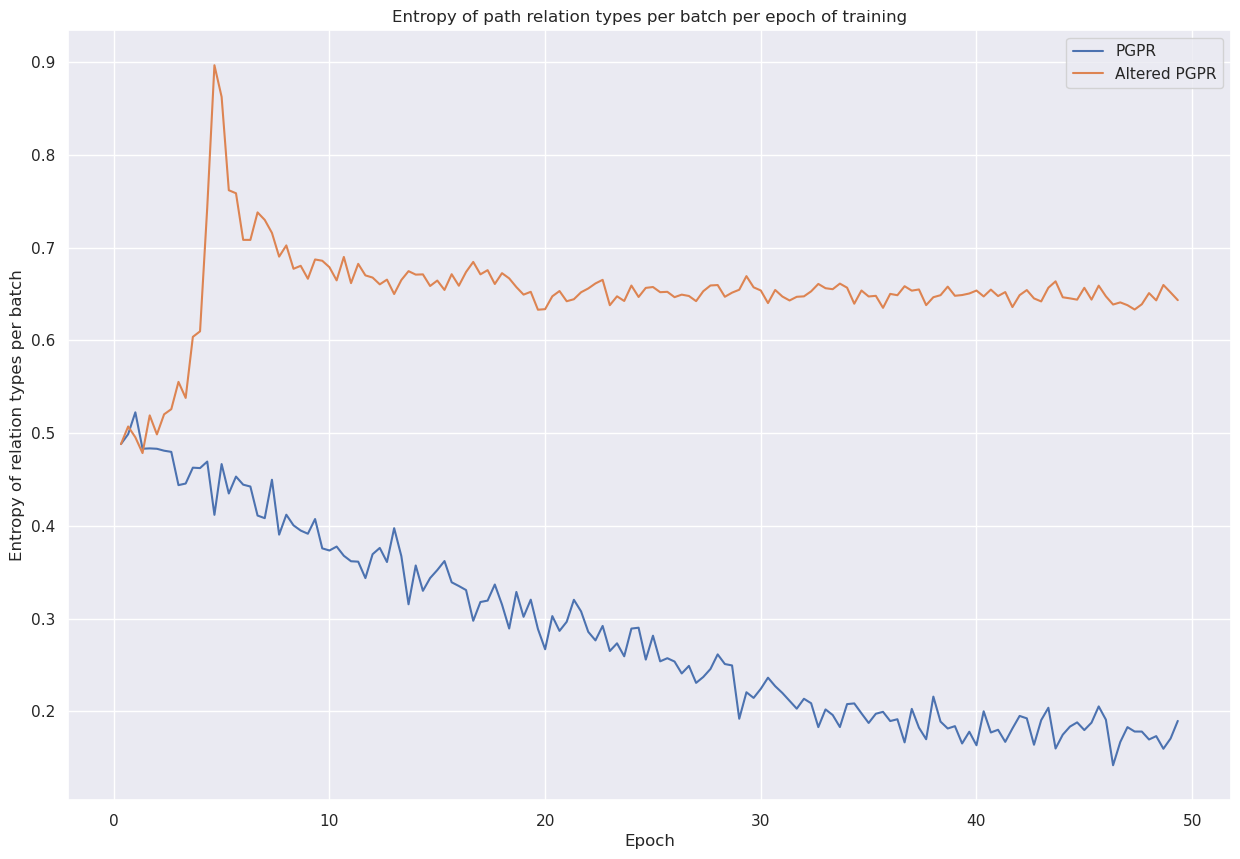

In [43]:
plt.figure(figsize=(15,10))
plt.title("Entropy of path relation types per batch per epoch of training")
plt.xlabel("Epoch")
plt.ylabel("Entropy of relation types per batch")

ax = sns.lineplot(x=range(1,149), y=relation_entropy_old, estimator="mean", label="PGPR")
ax.set_xticks([0, 30, 60, 90, 120, 150], labels=[0, 10, 20, 30, 40, 50])
ax = sns.lineplot(x=range(1,149), y=rel_entropy_new, estimator="mean", label="Altered PGPR")
ax.set_xticks([0, 30, 60, 90, 120, 150], labels=[0, 10, 20, 30, 40, 50])

In [39]:
ratio_new = [0.11234, 0.11797, 0.11531, 0.11406, 0.12578, 0.12375, 0.13531, 0.13828, 0.14578, 0.14406, 0.16922, 0.17062, 0.22062, 0.33234, 0.46828, 0.56812, 0.59156, 0.60484, 0.59422, 0.59750, 0.59578, 0.59906, 0.61250, 0.61391, 0.62187, 0.63875, 0.63906, 0.63187, 0.62250, 0.61344, 0.63328, 0.62250, 0.63422, 0.61313, 0.61891, 0.62547, 0.62766, 0.61813, 0.64047, 0.62313, 0.61375, 0.63484, 0.61016, 0.64687, 0.63203, 0.63781, 0.63047, 0.63094, 0.62078, 0.62938, 0.62203, 0.61391, 0.64375, 0.63141, 0.63187, 0.64406, 0.64500, 0.63562, 0.65906, 0.64297, 0.63656, 0.63281, 0.64859, 0.64938, 0.63469, 0.64828, 0.63516, 0.64000, 0.64953, 0.64734, 0.64297, 0.64062, 0.64938, 0.62781, 0.63047, 0.64156, 0.63734, 0.64609, 0.64000, 0.64250, 0.65422, 0.64266, 0.63641, 0.64297, 0.64984, 0.64469, 0.63219, 0.62203, 0.65172, 0.63062, 0.65516, 0.64516, 0.64375, 0.65141, 0.64234, 0.64297, 0.66109, 0.64594, 0.64703, 0.64594, 0.64234, 0.63875, 0.65438, 0.64297, 0.63656, 0.65516, 0.65687, 0.63375, 0.65156, 0.63375, 0.64406, 0.63172, 0.66156, 0.65234, 0.64687, 0.63875, 0.64750, 0.65438, 0.64578, 0.64484, 0.64203, 0.64250, 0.64297, 0.63391, 0.65766, 0.64797, 0.64187, 0.64875, 0.65109, 0.63672, 0.62391, 0.64609, 0.64781, 0.64609, 0.63828, 0.64641, 0.63078, 0.64891, 0.66906, 0.65875, 0.65797, 0.65156, 0.66063, 0.66187, 0.65187, 0.63250, 0.63406, 0.64219]

ratio_old = [0.11234, 0.11203, 0.12016, 0.10781, 0.11250, 0.11281, 0.11438, 0.11250, 0.10687, 0.10719, 0.11063, 0.11328, 0.11859, 0.10266, 0.11844, 0.10406, 0.11406, 0.12172, 0.11234, 0.10281, 0.10234, 0.11594, 0.09875, 0.10422, 0.10656, 0.10063, 0.10156, 0.10703, 0.09703, 0.09953, 0.09953, 0.09578, 0.09563, 0.09500, 0.09156, 0.10141, 0.09859, 0.09484, 0.10578, 0.09938, 0.08141, 0.09641, 0.08953, 0.09406, 0.09797, 0.09953, 0.09047, 0.09094, 0.09047, 0.08016, 0.08297, 0.08734, 0.09312, 0.08516, 0.07969, 0.08937, 0.08141, 0.08609, 0.07484, 0.07250, 0.07781, 0.07484, 0.08156, 0.08703, 0.08031, 0.07781, 0.07078, 0.07656, 0.07094, 0.07391, 0.06703, 0.08031, 0.07797, 0.06672, 0.07375, 0.06859, 0.06766, 0.06531, 0.06078, 0.06641, 0.05984, 0.05859, 0.06313, 0.06688, 0.06453, 0.06422, 0.04922, 0.05688, 0.05578, 0.05906, 0.05984, 0.05859, 0.05688, 0.05297, 0.05172, 0.05391, 0.05250, 0.04797, 0.04922, 0.05156, 0.04688, 0.05187, 0.05266, 0.04844, 0.04516, 0.05000, 0.05187, 0.04688, 0.04609, 0.04125, 0.05141, 0.04562, 0.04250, 0.05297, 0.04688, 0.04547, 0.04797, 0.03922, 0.04281, 0.04047, 0.04766, 0.04484, 0.04562, 0.04016, 0.04375, 0.04938, 0.04750, 0.03953, 0.04859, 0.04953, 0.03797, 0.04250, 0.04625, 0.04547, 0.04391, 0.04719, 0.05063, 0.04672, 0.03438, 0.03969, 0.04594, 0.04469, 0.04641, 0.04125, 0.04359, 0.03922, 0.04109, 0.04828]

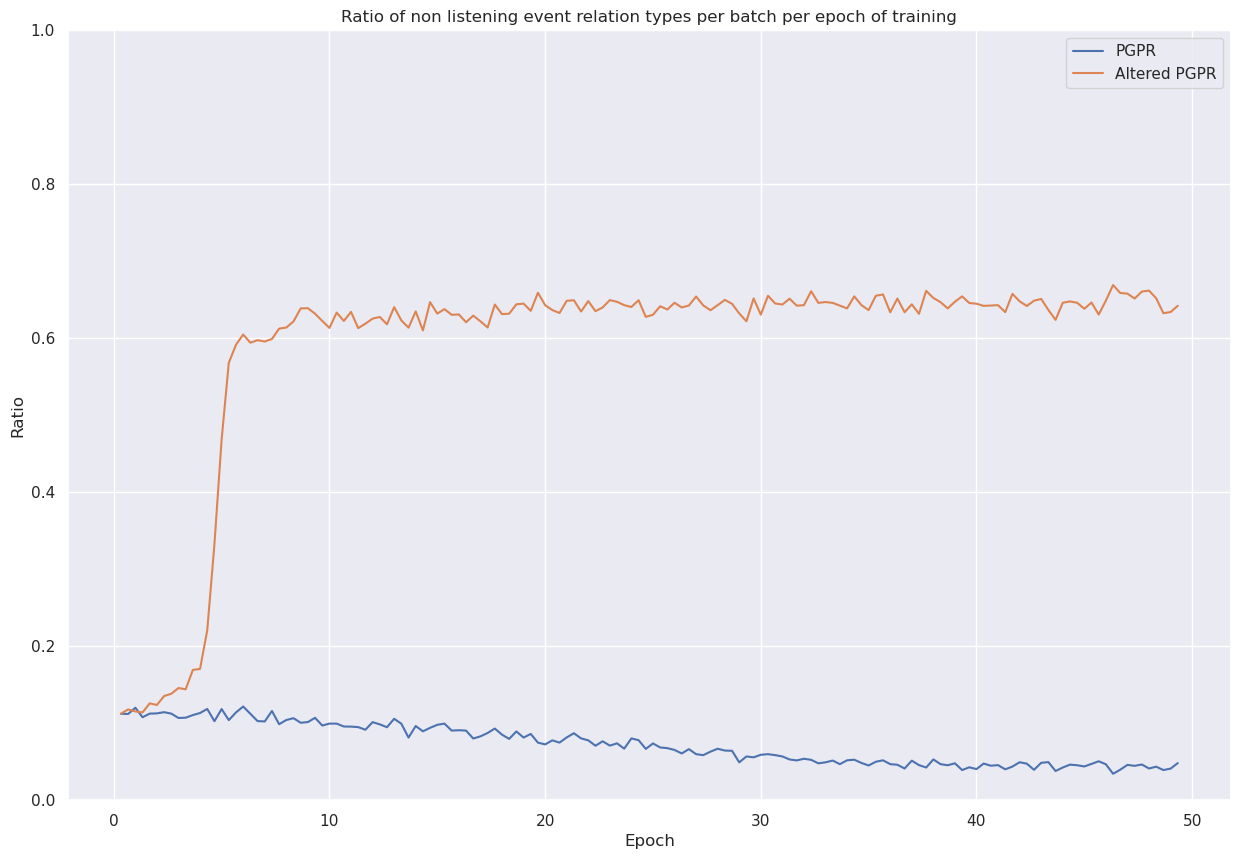

In [41]:
plt.figure(figsize=(15,10))
plt.title("Ratio of non listening event relation types per batch per epoch of training")
plt.xlabel("Epoch")
plt.ylabel("Ratio")
plt.ylim([0,1])

ax = sns.lineplot(x=range(1,149), y=ratio_old, estimator="mean", label="PGPR")
ax.set_xticks([0, 30, 60, 90, 120, 150], labels=[0, 10, 20, 30, 40, 50])
ax = sns.lineplot(x=range(1,149), y=ratio_new, estimator="mean", label="Altered PGPR")
ax.set_xticks([0, 30, 60, 90, 120, 150], labels=[0, 10, 20, 30, 40, 50])


<Axes: >

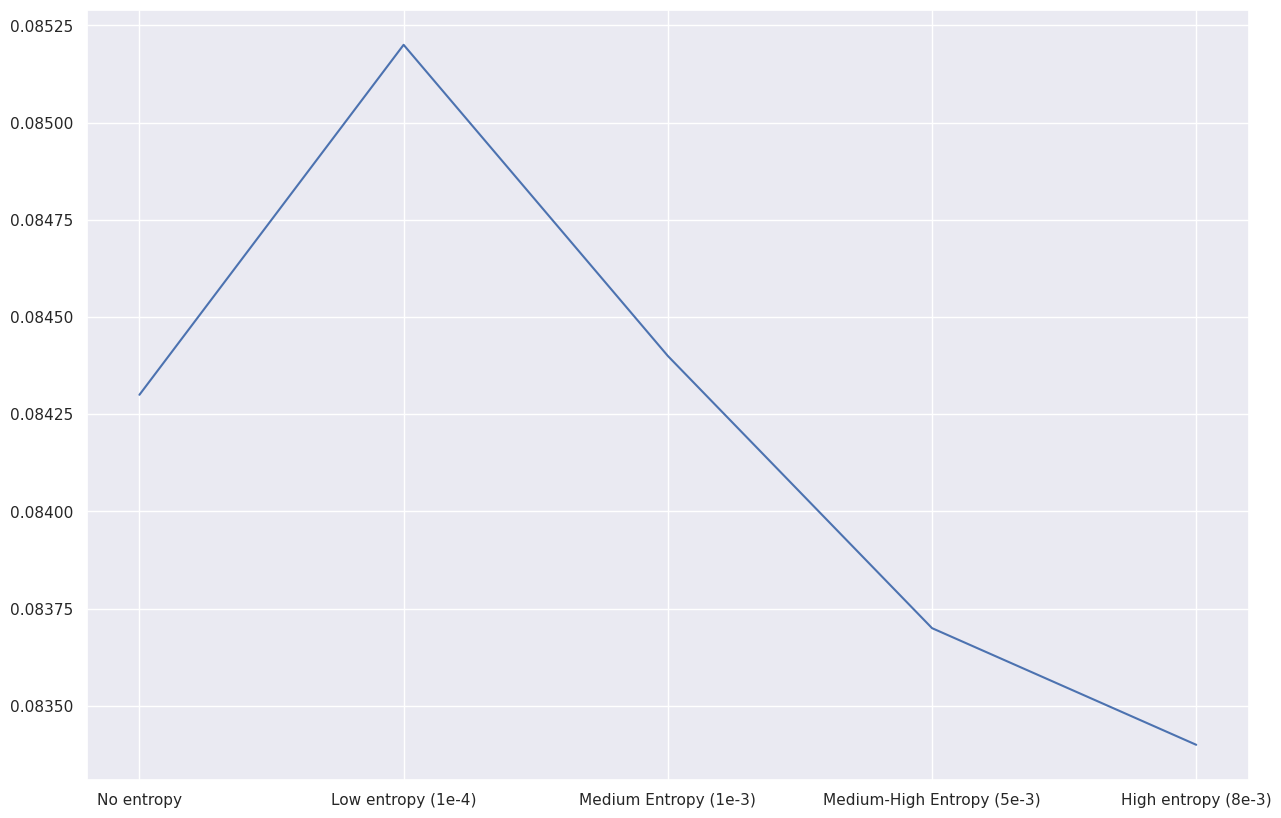

In [14]:
plt.figure(figsize=(15,10))
sns.lineplot(x=["No entropy", "Low entropy (1e-4)", "Medium Entropy (1e-3)", "Medium-High Entropy (5e-3)", "High entropy (8e-3)"], y=[0.0843, 0.0852, 0.0844, 0.0837, 0.0834])

In [2]:
with open("results/lfm/pgpr/pred_paths.pkl", 'rb') as pred_paths_file:
    pred_paths_pgpr = pickle.load(pred_paths_file)
pred_paths_file.close()

In [4]:
header = ["uid", "pid", "path_score", "path_prob", "path"]
pred_paths_map_pgpr = defaultdict(dict)
for record in pred_paths_pgpr:
    uid, pid, path_score, path_prob, path = record
    if pid not in pred_paths_map_pgpr[uid]:
        pred_paths_map_pgpr[uid][pid] = []
    pred_paths_map_pgpr[uid][pid].append((float(path_score), float(path_prob), path))

In [9]:
n_users = len(pred_paths_map_pgpr.keys())
random_user = randint(0, n_users)
random_product = choice(list(pred_paths_map_pgpr[random_user].keys()))
print(pred_paths_map_pgpr[random_user][random_product])
print(len(pred_paths_map_pgpr[random_user]))

[(0.557691845909847, 2.5638131774030626e-05, 'self_loop user 9163 listened_to product 40838 has_micro_genre micro_genre 961 has_micro_genre product 167643'), (0.557691845909847, 9.663195669418201e-06, 'self_loop user 9163 listened_to product 95256 has_micro_genre micro_genre 961 has_micro_genre product 167643')]
445


In [26]:
kg = pd.read_csv("data/lfm/intermediate_kg/kg.txt", sep="\t", names=["head", "relation", "tail"])
kg.head()

,head,relation,tail
0,t31469731,has_genre,pop
1,t11520441,has_genre,rock
2,t36346257,has_genre,pop
3,t13847831,has_genre,metal
4,t24342900,has_genre,folk


In [27]:
groups = kg.groupby("head")

In [28]:
le = pd.read_csv("data/lfm/cleaned/listening_events.tsv", sep="\t")
le.head()

,user_id,track_id,album_id,timestamp
0,16026,40012596,18558010,1577833201
1,42410,14250568,8916172,1577833201
2,39972,33291229,6630145,1577833201
3,7744,18394900,19722005,1577833202
4,14807,21889387,16391976,1577833203


In [37]:
c = []
for name, group in groups:
    name_trim = name[1:]
    track_le = le[le["track_id"] == int(name_trim)]
    counts = group['relation'].value_counts()
    c.append([len(track_le),counts["has_micro_genre"] if "has_micro_genre" in counts else 0, counts["has_genre"] if "has_genre" in counts else 0, counts["in_album"] if "in_album" in counts else 0, counts["created_by"] if "created_by" in counts else 0])

np.mean(c,axis=0)

array([29.65442483,  5.51109202,  0.92188081,  0.92188081,  0.92188081])

In [3]:
val = [29.654425,
5.511092,
0.921881,
0.921881,
0.921881,
]

In [30]:
(5.511092+3*0.921881 )/ 37.93116

0.21820410976094584

In [42]:
np.sum(val)

37.93116

In [6]:
[(v/np.sum(val)) for v in val]

[0.7817958902390542,
 0.1452919446702922,
 0.0243040550302179,
 0.0243040550302179,
 0.0243040550302179]

In [ ]:
1- (29.654425) / 37.93116

In [ ]:
1- (29.654425) / 37.93116